In [9]:
import os
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline


starcraft_ii_dirs = [
    '/home/joosep/PycharmProjects/StarCraftII/running/5v6-forward',
    '/home/joosep/PycharmProjects/StarCraftII/running-second/3sv5z-forward',
    '/home/joosep/PycharmProjects/StarCraftII/running-third/8m-forward',
    '/home/joosep/PycharmProjects/StarCraftII/running-fourth/3s5z-forward'
]
predator_prey_dirs = [
    '/home/joosep/PycharmProjects/StarCraft/latest/first-experiment/1613779707_5x5_1000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_100',
    '/home/joosep/PycharmProjects/StarCraft/latest/first-experiment/1613797630_5x5_2000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_100',
    '/home/joosep/PycharmProjects/StarCraft/latest/first-experiment/1613815249_5x5_3000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_100',
    '/home/joosep/PycharmProjects/StarCraft/latest/first-experiment/1613833504_5x5_4000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_100',
    '/home/joosep/PycharmProjects/StarCraft/latest/first-experiment/1613854780_5x5_5000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_100',
    '/home/joosep/PycharmProjects/StarCraft/latest/first-experiment/1613875551_5x5_6000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_100',
    '/home/joosep/PycharmProjects/StarCraft/latest/first-experiment/1613922704_5x5_7000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_100',
    '/home/joosep/PycharmProjects/StarCraft/latest/first-experiment/1613942105_5x5_8000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_100',
    '/home/joosep/PycharmProjects/StarCraft/latest/first-experiment/1613961387_5x5_9000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_100',
    '/home/joosep/PycharmProjects/StarCraft/latest/first-experiment/1613978319_5x5_10000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_100',
    '/home/joosep/PycharmProjects/StarCraft/latest/second-experiment/1614135587_5x5_1000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_101',
    '/home/joosep/PycharmProjects/StarCraft/latest/second-experiment/1614146175_5x5_2000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_101',
    '/home/joosep/PycharmProjects/StarCraft/latest/second-experiment/1614161230_5x5_3000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_101',
    '/home/joosep/PycharmProjects/StarCraft/latest/second-experiment/1614173715_5x5_4000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_101',
    '/home/joosep/PycharmProjects/StarCraft/latest/second-experiment/1614198568_5x5_5000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_101',
    '/home/joosep/PycharmProjects/StarCraft/latest/second-experiment/1614216305_5x5_6000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_101',
    '/home/joosep/PycharmProjects/StarCraft/latest/second-experiment/1614234469_5x5_7000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_101',
    '/home/joosep/PycharmProjects/StarCraft/latest/second-experiment/1614253393_5x5_8000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_101',
    '/home/joosep/PycharmProjects/StarCraft/latest/second-experiment/1614301353_5x5_9000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_101',
    '/home/joosep/PycharmProjects/StarCraft/latest/second-experiment/1614327414_5x5_10000_to_12x12_10A5P_fullmono_notime_noreset_epsilon_eval_seed_101',
]

np.set_printoptions(precision=2)

def find_switch(logfile):
    switch_time = re.compile(r'.*next task @ (?P<switch>\d+)')
    with open(logfile, 'r') as f:
        for line in f:
            if matches := re.match(switch_time, line):
                switch = int(matches.group('switch')) // 5000
                return switch
        raise RuntimeError("Switch not found; is this the right curriculum?")


def find_data(exp_dir):
    data = defaultdict(dict)
    old_switch = None
    for root, dirs, files in os.walk(exp_dir):
        for fname in files:
            if old_switch is None:
                try:
                    timestamp, size, switch, *rest = root.split('_')
                    old_switch = True
                    data[Path(root).stem]['switch'] = int(switch) // 100
                except ValueError:
                    old_switch = False
            if 'eval_rewards.npy' == fname:
                path = os.path.join(root, fname)
                data[Path(root).stem]['eval_rewards'] = np.load(path).reshape(-1, 1)
            elif 'win_rates.npy' == fname:
                path = os.path.join(root, fname)
                data[Path(root).stem]['win_rates'] = np.load(path).reshape(-1, 1)
            elif 'train_rewards.npy' == fname:
                pass
            elif 'out.log' == fname:
                path = os.path.join(root, fname)
                data[Path(root).stem]['switch'] = find_switch(path)
            elif 'data.npz' == fname:
                path = os.path.join(root, fname)
                d = np.load(path)

                # this is the correct shape for this data; we did evaluate for 100 episodes
                # we take the first 200 mean episode rewards because in the second experiment,
                # we let the agents train for 20k episodes in the hard task, but let the agents
                # train 20k-before_switch in the hard task in our first experiment.
                data[Path(root).stem]['eval_rewards'] = d['eval_ep_reward'].reshape(-1, 100)[:200]
                data[Path(root).stem]['win_rates'] = d['eval_win_tag'].reshape(-1, 100)[:200]

    return data


def score_axes(axes):
    """
    Return the R^2 scores for the scatterplots for each axis in axes.
    """
    scatters = []
    for row in axes:
        scatter_row = []
        for plot in row:
            data = np.array([coll.get_offsets().ravel() for coll in plot.collections])
            X, y = np.split(data, [1], axis=1)
            scatter_row.append((X, y.ravel()))
        scatters.append(scatter_row)
    #%%
    from sklearn.linear_model import LinearRegression
    scores = []
    for ax_row, scatter_row in zip(axes, scatters):
        for ax, (X, y) in zip(ax_row, scatter_row):
            model = LinearRegression(fit_intercept=True)
            model.fit(X, y)
            R2 = model.score(X, y)
            scores.append(R2)
    scores = np.reshape(scores, axes.shape)
    return scores


def before_after_plots(runs, steps_before_switch, suptitle=None):
    fig, axes = plt.subplots(len(steps_before_switch), 4)
    fig.set_size_inches(3 * 4, 3 * len(steps_before_switch))
    if suptitle:
        fig.suptitle(suptitle, fontsize=16)

    # for ax in axes.ravel():
    # ax.set_xlabel('Expected Win Rate Before Switch,\n last 10 evaluation steps')
    # ax.set_xlim(left=0, right=30)
    # ax.set_ylim(bottom=0, top=30)

    for ts_before, plot_ax in zip(steps_before_switch, axes):
        plot_ax[0].set_xlabel('Mean, Before Switch')
        plot_ax[1].set_xlabel('Max,  Before Switch')
        plot_ax[2].set_xlabel('Mean, Before Switch')
        plot_ax[3].set_xlabel('Max,  Before Switch')

        plot_ax[0].set_ylabel('Mean, After Switch')
        plot_ax[1].set_ylabel('Mean, After Switch')
        plot_ax[2].set_ylabel('Max,  After Switch')
        plot_ax[3].set_ylabel('Max,  After Switch')

        for ax in plot_ax:
            if ts_before < 0:
                ax.set_title(f'All timesteps Before Switch')
            else:
                ax.set_title(f'{ts_before * 5}k timesteps Before Switch')


    for run in runs:
        for t, ax in zip(steps_before_switch, axes):
            for name, data in run.items():
                if t < 0:
                    before, after = np.split(data['eval_rewards'], [data['switch']])
                else:
                    _, before, after = np.split(data['eval_rewards'], [data['switch'] - t, data['switch']])
                ax[0].scatter(np.mean(before), np.mean(after), alpha=0.7)
                ax[1].scatter(np.max(before), np.mean(after), alpha=0.7)
                ax[2].scatter(np.mean(before), np.max(after), alpha=0.7)
                ax[3].scatter(np.max(before), np.max(after), alpha=0.7)

    return fig, axes


def reward_battle(enemies):
    """
    Reward function when self.reward_spare==False.
    Returns accumulative hit/shield point damage dealt to the enemy
    + reward_death_value per enemy unit killed, and, in case
    reward_only_positive == False, - (damage dealt to ally units
    + reward_death_value per ally unit killed) * self.reward_negative_scale
    """
    reward = 0
    delta_deaths = 0
    delta_enemy = 0
    reward_only_positive = True
    reward_death_value = 10
    reward_scale_rate = 20
    reward_win = 200
    n_enemies = 0
    total_hp = 0
    total_shield = 0

    for n, hp, shield in enemies:
        delta_enemy  += n*(hp+shield)
        total_hp += n*hp
        total_shield += n*shield
        delta_deaths += n*(reward_death_value)
        n_enemies += n

    max_reward = (reward_death_value * n_enemies  + reward_win)
    max_reward += total_hp # in smac, they add unit.max_shield, which is 0, but unit.shield is nonzero...

    if reward_only_positive:
        reward = abs(delta_enemy + delta_deaths)  # shield regeneration
    else:
        assert 0, "Never"

    reward += reward_win

    # print(f'{max_reward=}, {delta_enemy=}, {delta_deaths=}')
    reward /= max_reward / reward_scale_rate

    return reward

map_5mv6m = [
    (6, 45, 0)
]
map_3sv5z = [
    (5, 100, 50)
]
map_8m = [
    (8, 45, 0)
]
map_3s5z = [
    (3, 80, 80),
    (5, 100, 50)
]
maps = [
    map_5mv6m,
    map_3sv5z,
    map_8m,
    map_3s5z
]
STEP = 5000

starcraft_ii_max_rewards = []
for m in maps:
    starcraft_ii_max_rewards.append(reward_battle(m))

# based on plots, 26 is too small
starcraft_ii_max_rewards[1] = 30.0
starcraft_ii_max_rewards[3] = 30.0
predator_max_rewards = [250.0] * len(predator_prey_dirs)

before_switch = [
    1 * 5000 // STEP,
    2 * 5000 // STEP,
    5 * 5000 // STEP,
    10 * 5000 // STEP,
    -1,
    # 25 * 5000 // STEP,
    # 50 * 5000 // STEP,
]


def annotated_imshow(scores, suptitle):
    fig, axes = plt.subplots()
    fig.set_size_inches(8,8)
    img = axes.imshow(scores, vmin=-1, vmax=1, cmap='PiYG')
    axes.axis('off')
    fig.suptitle(suptitle, fontsize=16)
    plt.colorbar(img, ax=axes)

    rows, cols = scores.shape
    for i in range(rows):
        for j in range(cols):
            text = axes.text(j, i, round(scores[i, j],3), ha="center", va="center", color="black")

    return fig, axes

In [10]:
# starcraft data doesn't need reshaping, we are already working with
# mean episode rewards, e.g. shape (506,)
starcraft_ii_data = []
for exp in starcraft_ii_dirs:
    data = find_data(exp)
    starcraft_ii_data.append(data)

predator_prey_data = []
for exp in predator_prey_dirs:
    data = find_data(exp)
    for name, run in data.items():
        run['eval_rewards'] = np.mean(run['eval_rewards'], axis=1)
    predator_prey_data.append(data)

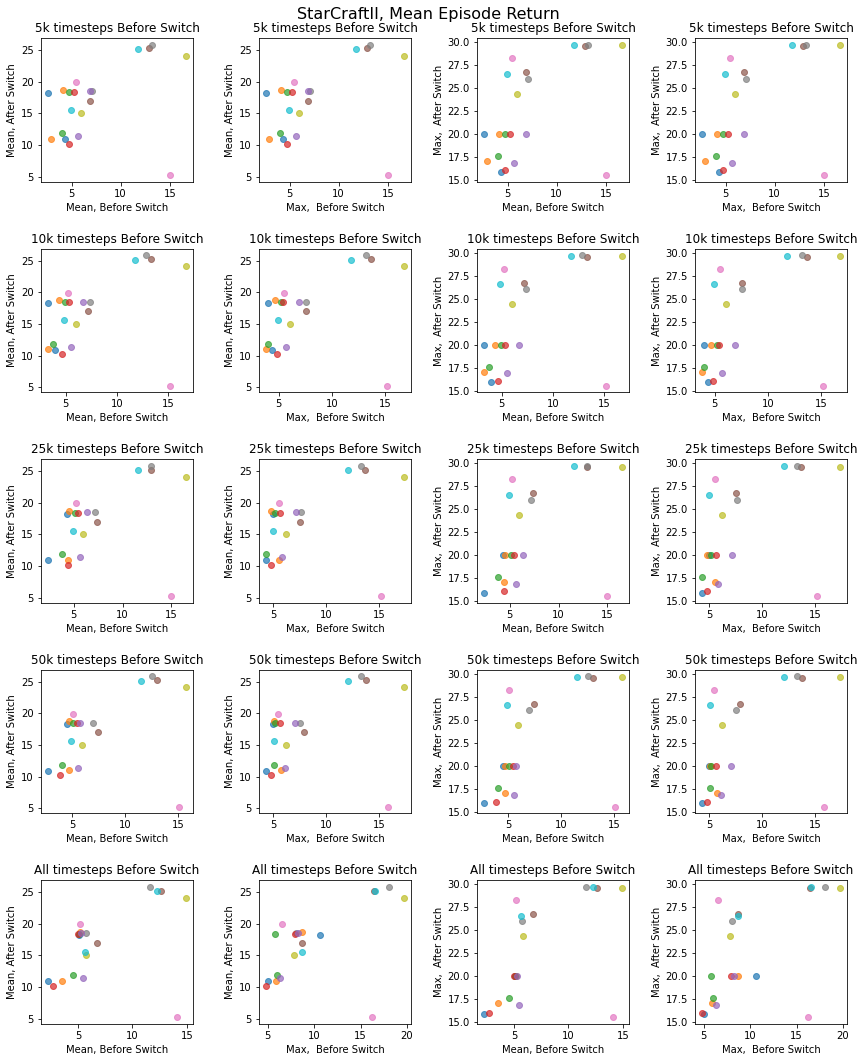

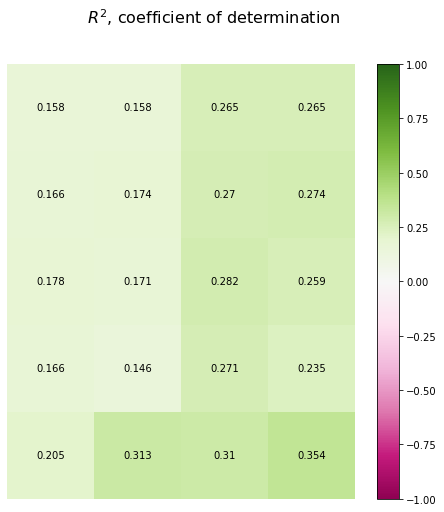

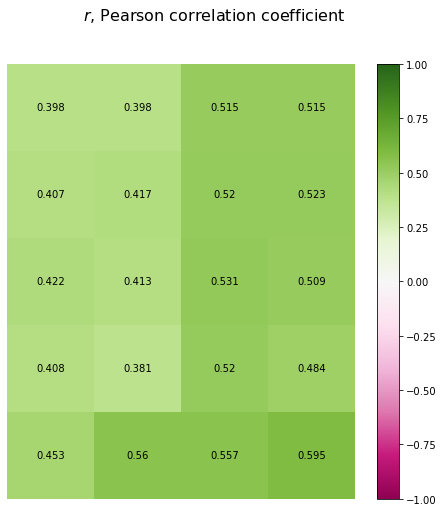

In [11]:
fig, axes = before_after_plots(starcraft_ii_data, before_switch, suptitle='StarCraftII, Mean Episode Return')
plt.tight_layout(h_pad=2, w_pad=2)
plt.show()
scores = score_axes(axes)

fig, axes = annotated_imshow(scores, '$R^2$, coefficient of determination')
plt.show()

fig, axes = annotated_imshow(np.sqrt(scores), '$r$, Pearson correlation coefficient')
plt.show()

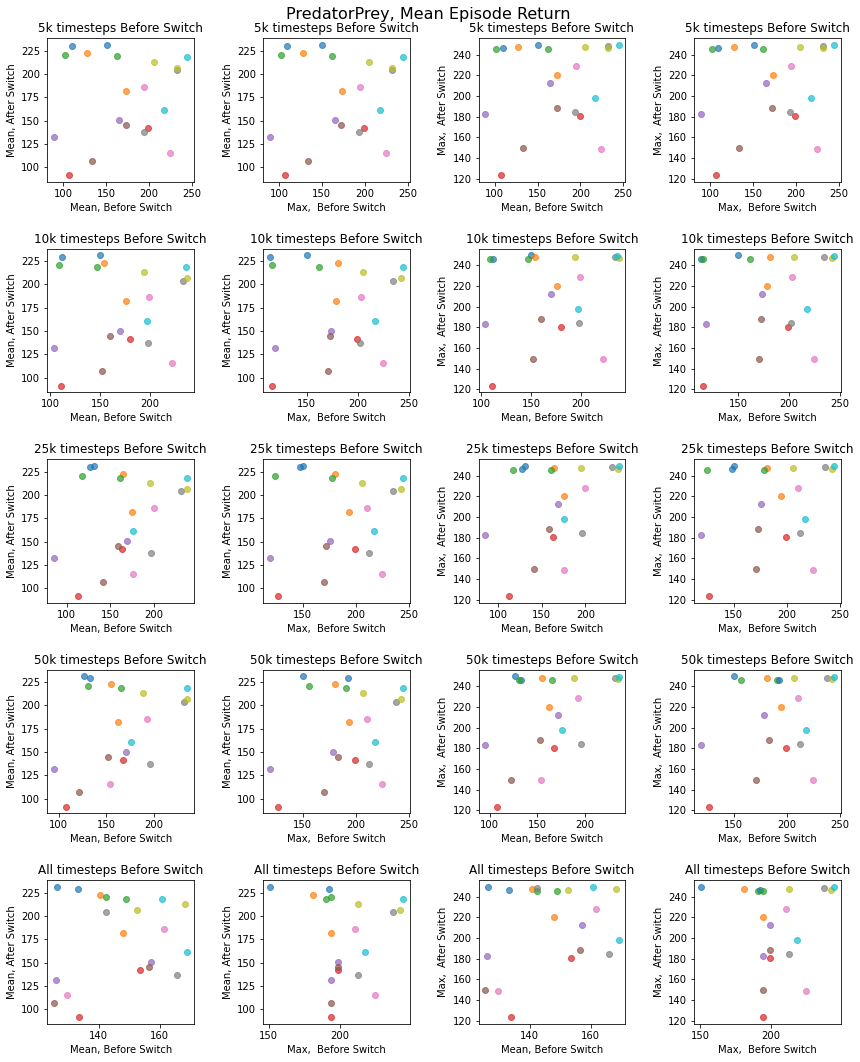

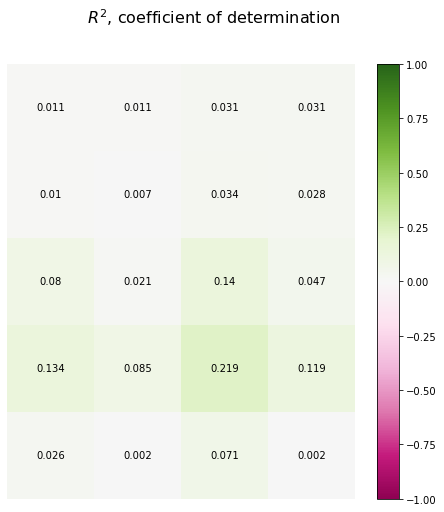

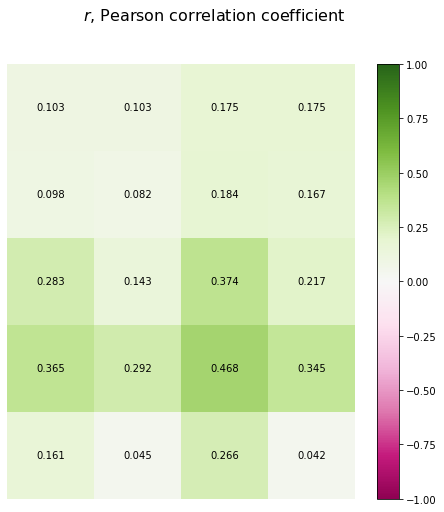

In [12]:
fig, axes = before_after_plots(predator_prey_data, before_switch, suptitle='PredatorPrey, Mean Episode Return')
plt.tight_layout(h_pad=2, w_pad=2)
plt.show()


scores = score_axes(axes)

fig, axes = annotated_imshow(scores, '$R^2$, coefficient of determination')
plt.show()

fig, axes = annotated_imshow(np.sqrt(scores), '$r$, Pearson correlation coefficient')
plt.show()

In [13]:
# divide by max reward to put all data on 1 plot
for exp, max_rew in zip(starcraft_ii_data, starcraft_ii_max_rewards):
    for run in exp.values():
        run['eval_rewards'] = run['eval_rewards'] / max_rew

for exp, max_rew in zip(predator_prey_data, predator_max_rewards):
    for run in exp.values():
        run['eval_rewards'] = run['eval_rewards'] / max_rew


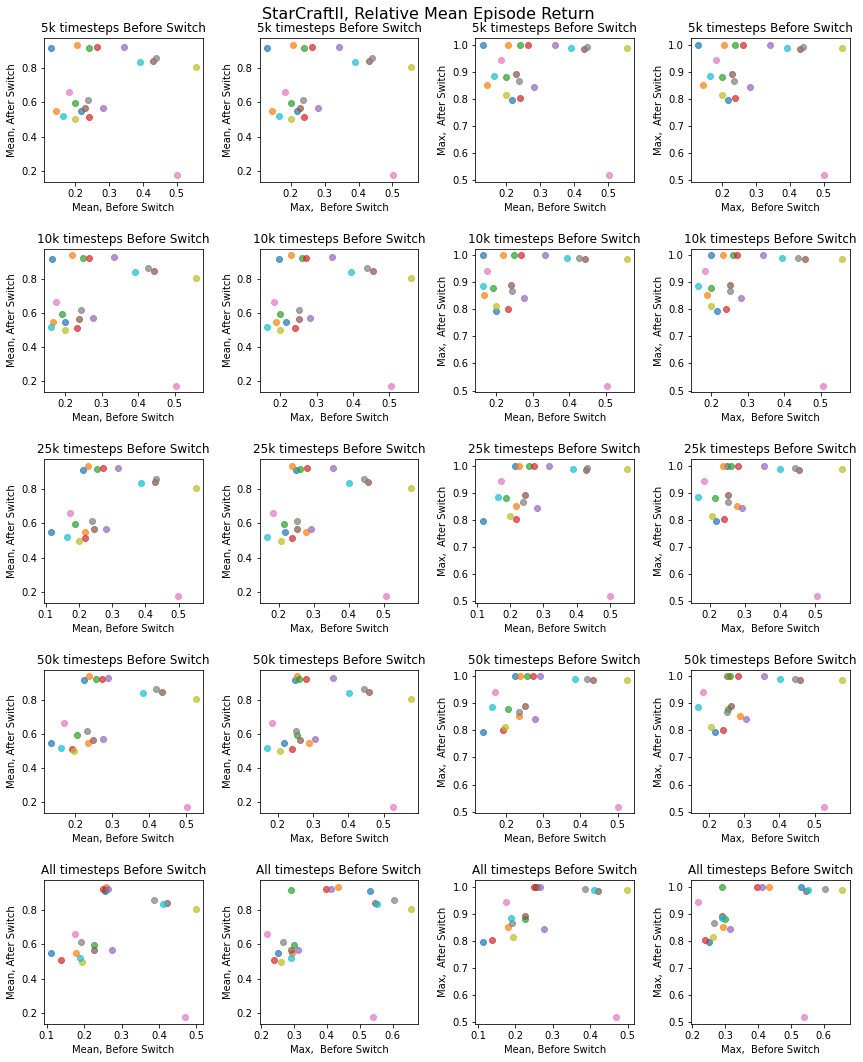

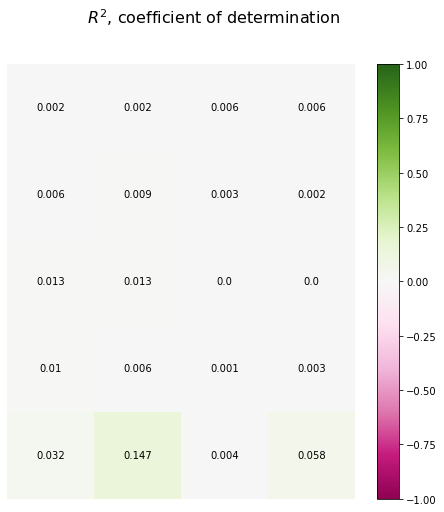

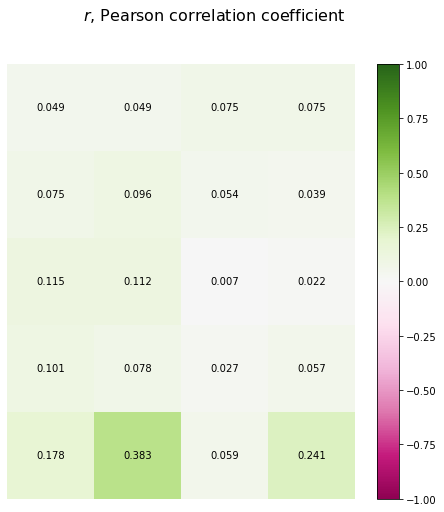

In [14]:
fig, axes = before_after_plots(starcraft_ii_data, before_switch, suptitle='StarCraftII, Relative Mean Episode Return')
plt.tight_layout(h_pad=2, w_pad=2)
plt.savefig('when-to-switch-plots/sc2-relative.png', dpi=300)
plt.show()

scores = score_axes(axes)

fig, axes = annotated_imshow(scores, '$R^2$, coefficient of determination')
plt.savefig('when-to-switch-plots/sc2-relative-R^2.png', dpi=300)
plt.show()

fig, axes = annotated_imshow(np.sqrt(scores), '$r$, Pearson correlation coefficient')
plt.savefig('when-to-switch-plots/sc2-relative-r.png', dpi=300)
plt.show()

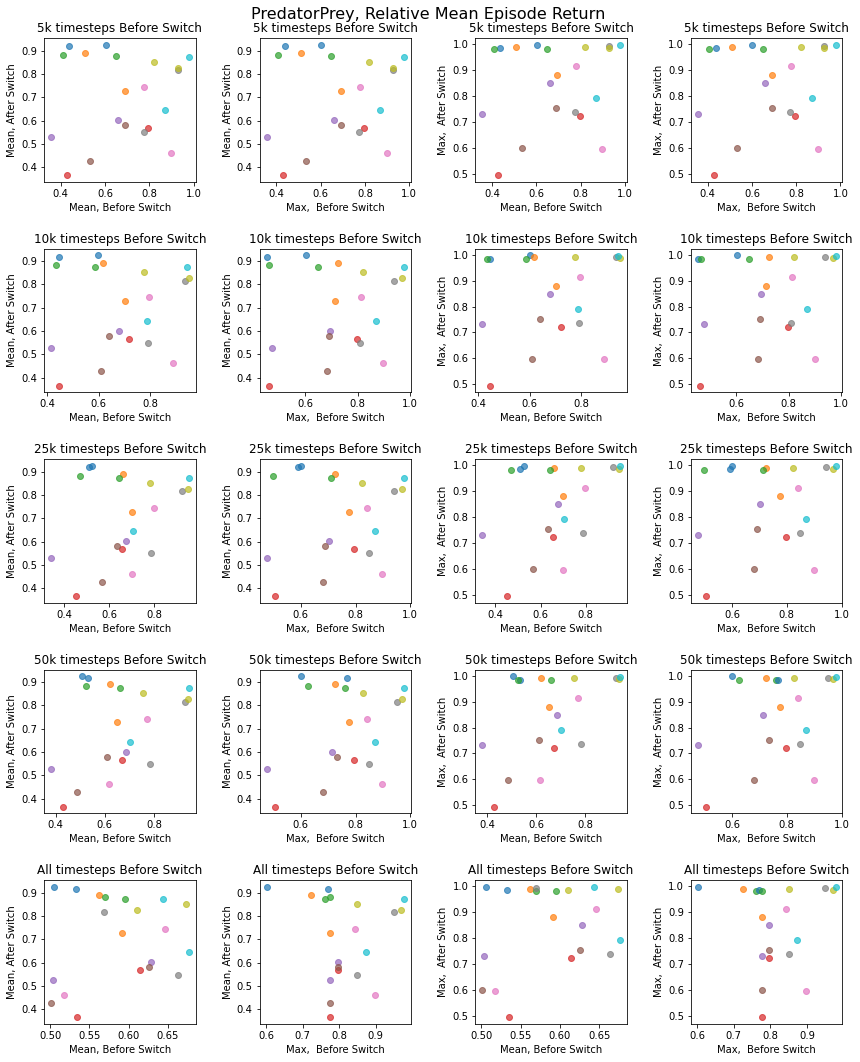

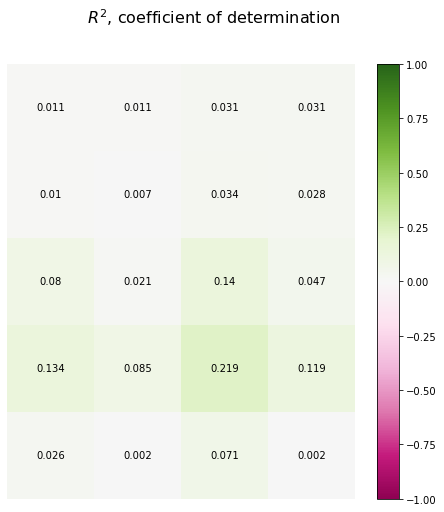

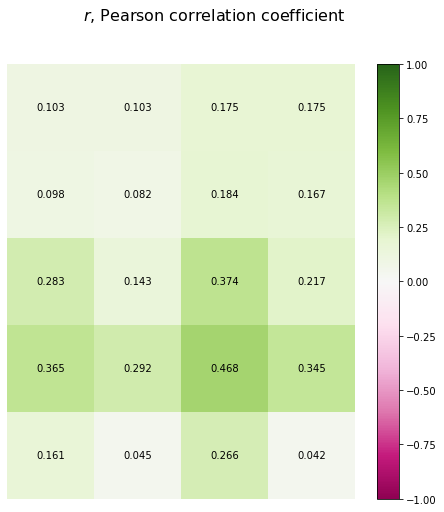

In [15]:
fig, axes = before_after_plots(predator_prey_data, before_switch, suptitle='PredatorPrey, Relative Mean Episode Return')
plt.tight_layout(h_pad=2, w_pad=2)
plt.savefig('when-to-switch-plots/PredatorPrey-relative.png', dpi=300)
plt.show()

scores = score_axes(axes)

fig, axes = annotated_imshow(scores, '$R^2$, coefficient of determination')
plt.savefig('when-to-switch-plots/PredatorPrey-relative-R^2.png', dpi=300)
plt.show()

fig, axes = annotated_imshow(np.sqrt(scores), '$r$, Pearson correlation coefficient')
plt.savefig('when-to-switch-plots/PredatorPrey-relative-r.png', dpi=300)
plt.show()

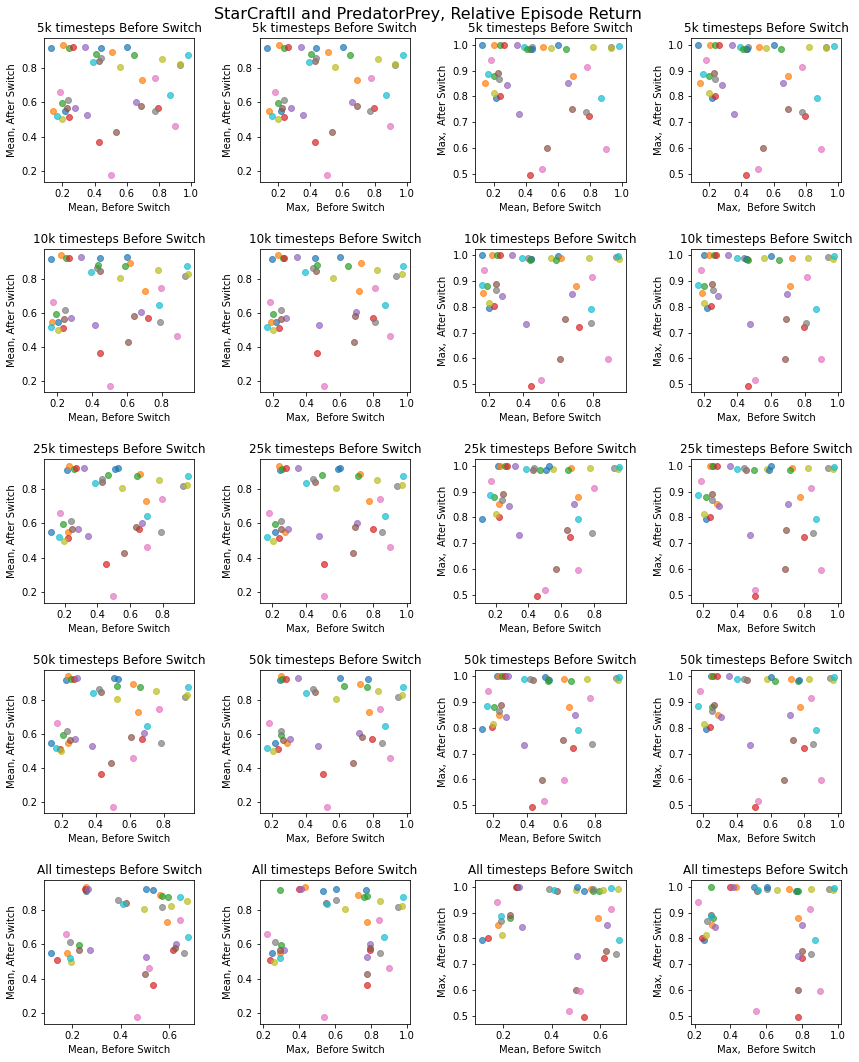

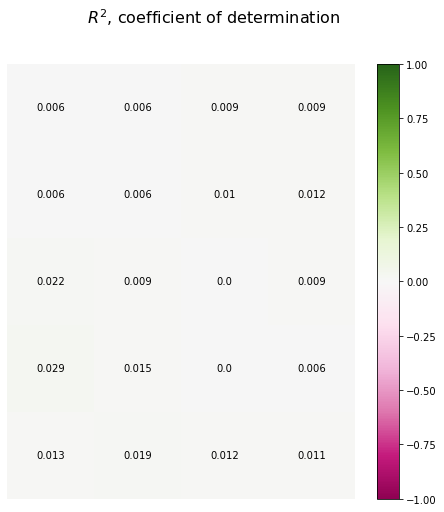

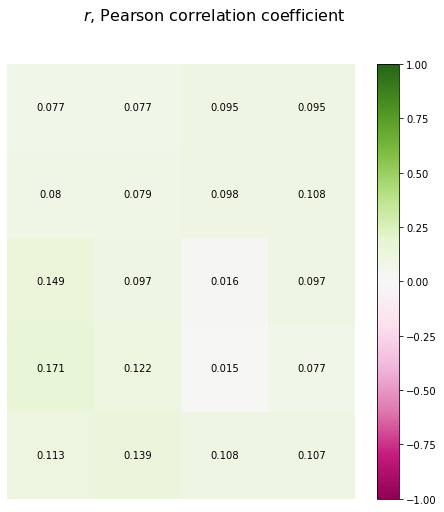

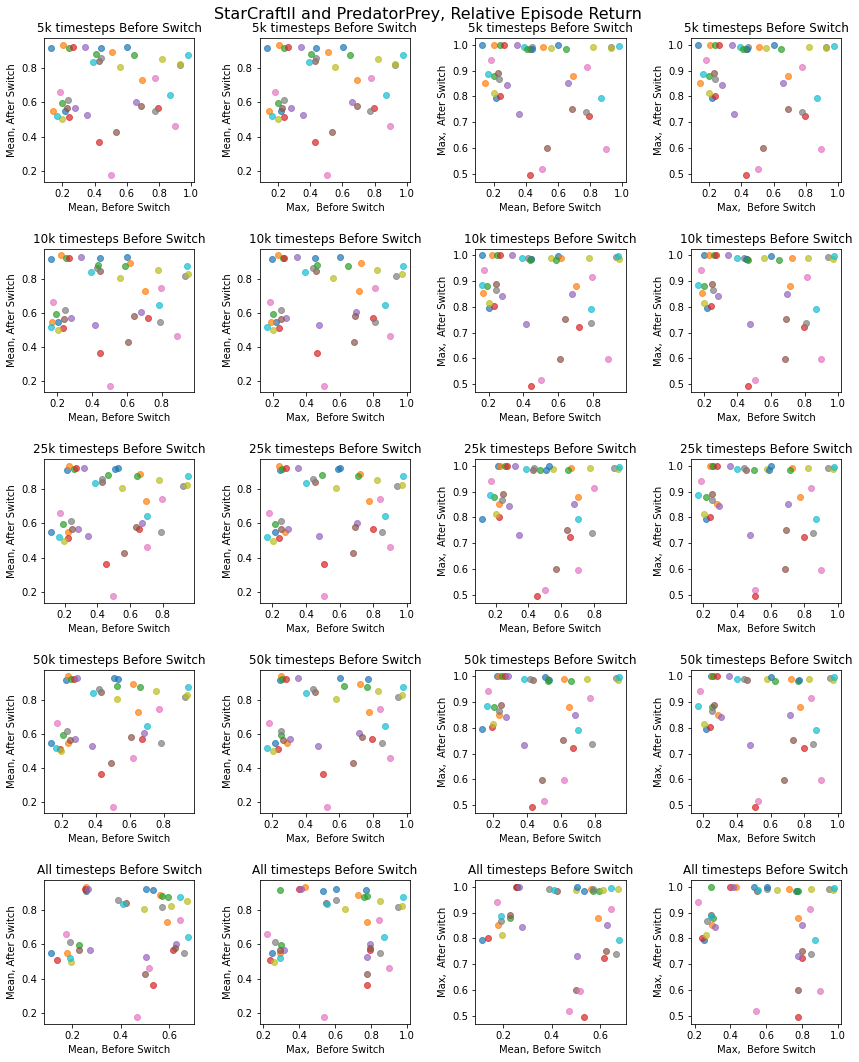

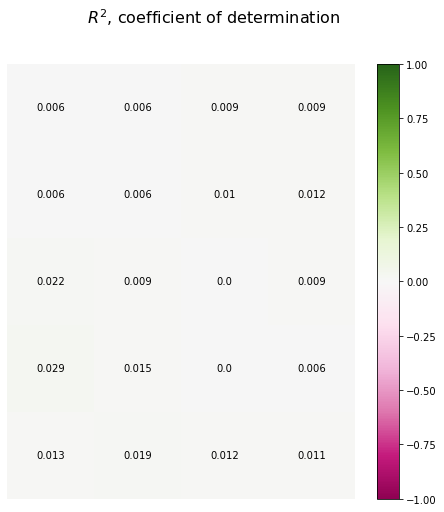

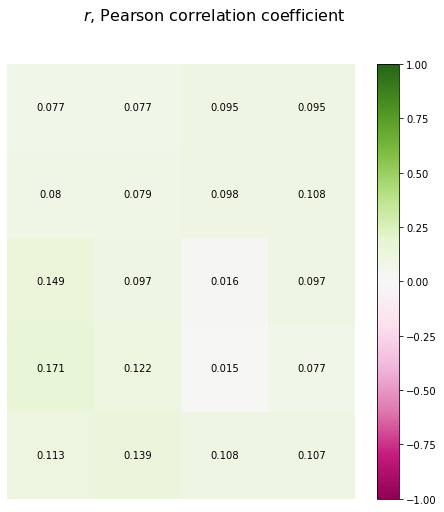

In [16]:
fig, axes = before_after_plots(starcraft_ii_data + predator_prey_data, before_switch, suptitle='StarCraftII and PredatorPrey, Relative Episode Return')
plt.tight_layout(h_pad=2, w_pad=2)
plt.savefig('when-to-switch-plots/sc2+PredatorPrey-relative.png', dpi=300)
plt.show()

scores = score_axes(axes)

fig, axes = annotated_imshow(scores, '$R^2$, coefficient of determination')
plt.savefig('when-to-switch-plots/sc2+PredatorPrey-relative-R^2.png', dpi=300)
plt.show()

fig, axes = annotated_imshow(np.sqrt(scores), '$r$, Pearson correlation coefficient')
plt.savefig('when-to-switch-plots/sc2+PredatorPrey-relative-r.png', dpi=300)
plt.show()

